### **Librerias y Dataset**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import utils
import kagglehub
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

In [2]:
# Descargar el dataset
path = kagglehub.dataset_download("muhammadshahidazeem/customer-churn-dataset")
print("Path to dataset files:", path)
# Cargar el dataset
dataset_path = os.path.join(path, "customer_churn_dataset-training-master.csv")
df = pd.read_csv(dataset_path)

Path to dataset files: C:\Users\guill\.cache\kagglehub\datasets\muhammadshahidazeem\customer-churn-dataset\versions\1


### **Exploratory Data Analysis**

In [3]:
print("Dimensiones del dataset:")
print(f"Features: {df.shape[1]}, Ejemplos: {df.shape[0]}")
print("Primeras 5 filas del dataset:")
df.head(10)

Dimensiones del dataset:
Features: 12, Ejemplos: 440833
Primeras 5 filas del dataset:


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,2.0,30.0,Female,39.0,14.0,5.0,18.0,Standard,Annual,932.0,17.0,1.0
1,3.0,65.0,Female,49.0,1.0,10.0,8.0,Basic,Monthly,557.0,6.0,1.0
2,4.0,55.0,Female,14.0,4.0,6.0,18.0,Basic,Quarterly,185.0,3.0,1.0
3,5.0,58.0,Male,38.0,21.0,7.0,7.0,Standard,Monthly,396.0,29.0,1.0
4,6.0,23.0,Male,32.0,20.0,5.0,8.0,Basic,Monthly,617.0,20.0,1.0
5,8.0,51.0,Male,33.0,25.0,9.0,26.0,Premium,Annual,129.0,8.0,1.0
6,9.0,58.0,Female,49.0,12.0,3.0,16.0,Standard,Quarterly,821.0,24.0,1.0
7,10.0,55.0,Female,37.0,8.0,4.0,15.0,Premium,Annual,445.0,30.0,1.0
8,11.0,39.0,Male,12.0,5.0,7.0,4.0,Standard,Quarterly,969.0,13.0,1.0
9,12.0,64.0,Female,3.0,25.0,2.0,11.0,Standard,Quarterly,415.0,29.0,1.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440833 entries, 0 to 440832
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   CustomerID         440832 non-null  float64
 1   Age                440832 non-null  float64
 2   Gender             440832 non-null  object 
 3   Tenure             440832 non-null  float64
 4   Usage Frequency    440832 non-null  float64
 5   Support Calls      440832 non-null  float64
 6   Payment Delay      440832 non-null  float64
 7   Subscription Type  440832 non-null  object 
 8   Contract Length    440832 non-null  object 
 9   Total Spend        440832 non-null  float64
 10  Last Interaction   440832 non-null  float64
 11  Churn              440832 non-null  float64
dtypes: float64(9), object(3)
memory usage: 40.4+ MB


Eliminamos la columna CustomerID porque no aporta nada relevante

In [5]:
# Elimina la columna CustomerID
df.drop('CustomerID', axis=1, inplace=True)

#### **Verificacion de NaN**

In [6]:
utils.calculate_na_statistics(df)

,datos sin NAs en q,Na en q,Na en %
Age,440832,1,0.0
Gender,440832,1,0.0
Tenure,440832,1,0.0
Usage Frequency,440832,1,0.0
Support Calls,440832,1,0.0
Payment Delay,440832,1,0.0
Subscription Type,440832,1,0.0
Contract Length,440832,1,0.0
Total Spend,440832,1,0.0
Last Interaction,440832,1,0.0


Filtramos la columna con NaN

In [7]:
nan_rows = df[df.isnull().any(axis=1)]

# Mostrar las filas con NaN
nan_rows.head()

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
199295,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Eliminamos esa columna porque no tiene nada

In [8]:
df.dropna(inplace=True)

#### **Analisis de duplicados**

In [9]:
duplicados = df.duplicated() # Identificar duplicados
num_duplicados = duplicados.sum() # Contar el número de duplicados
print(f"Número de registros duplicados en el dataset: {num_duplicados}")

Número de registros duplicados en el dataset: 0


#### **Analisis de distribucion de variables**

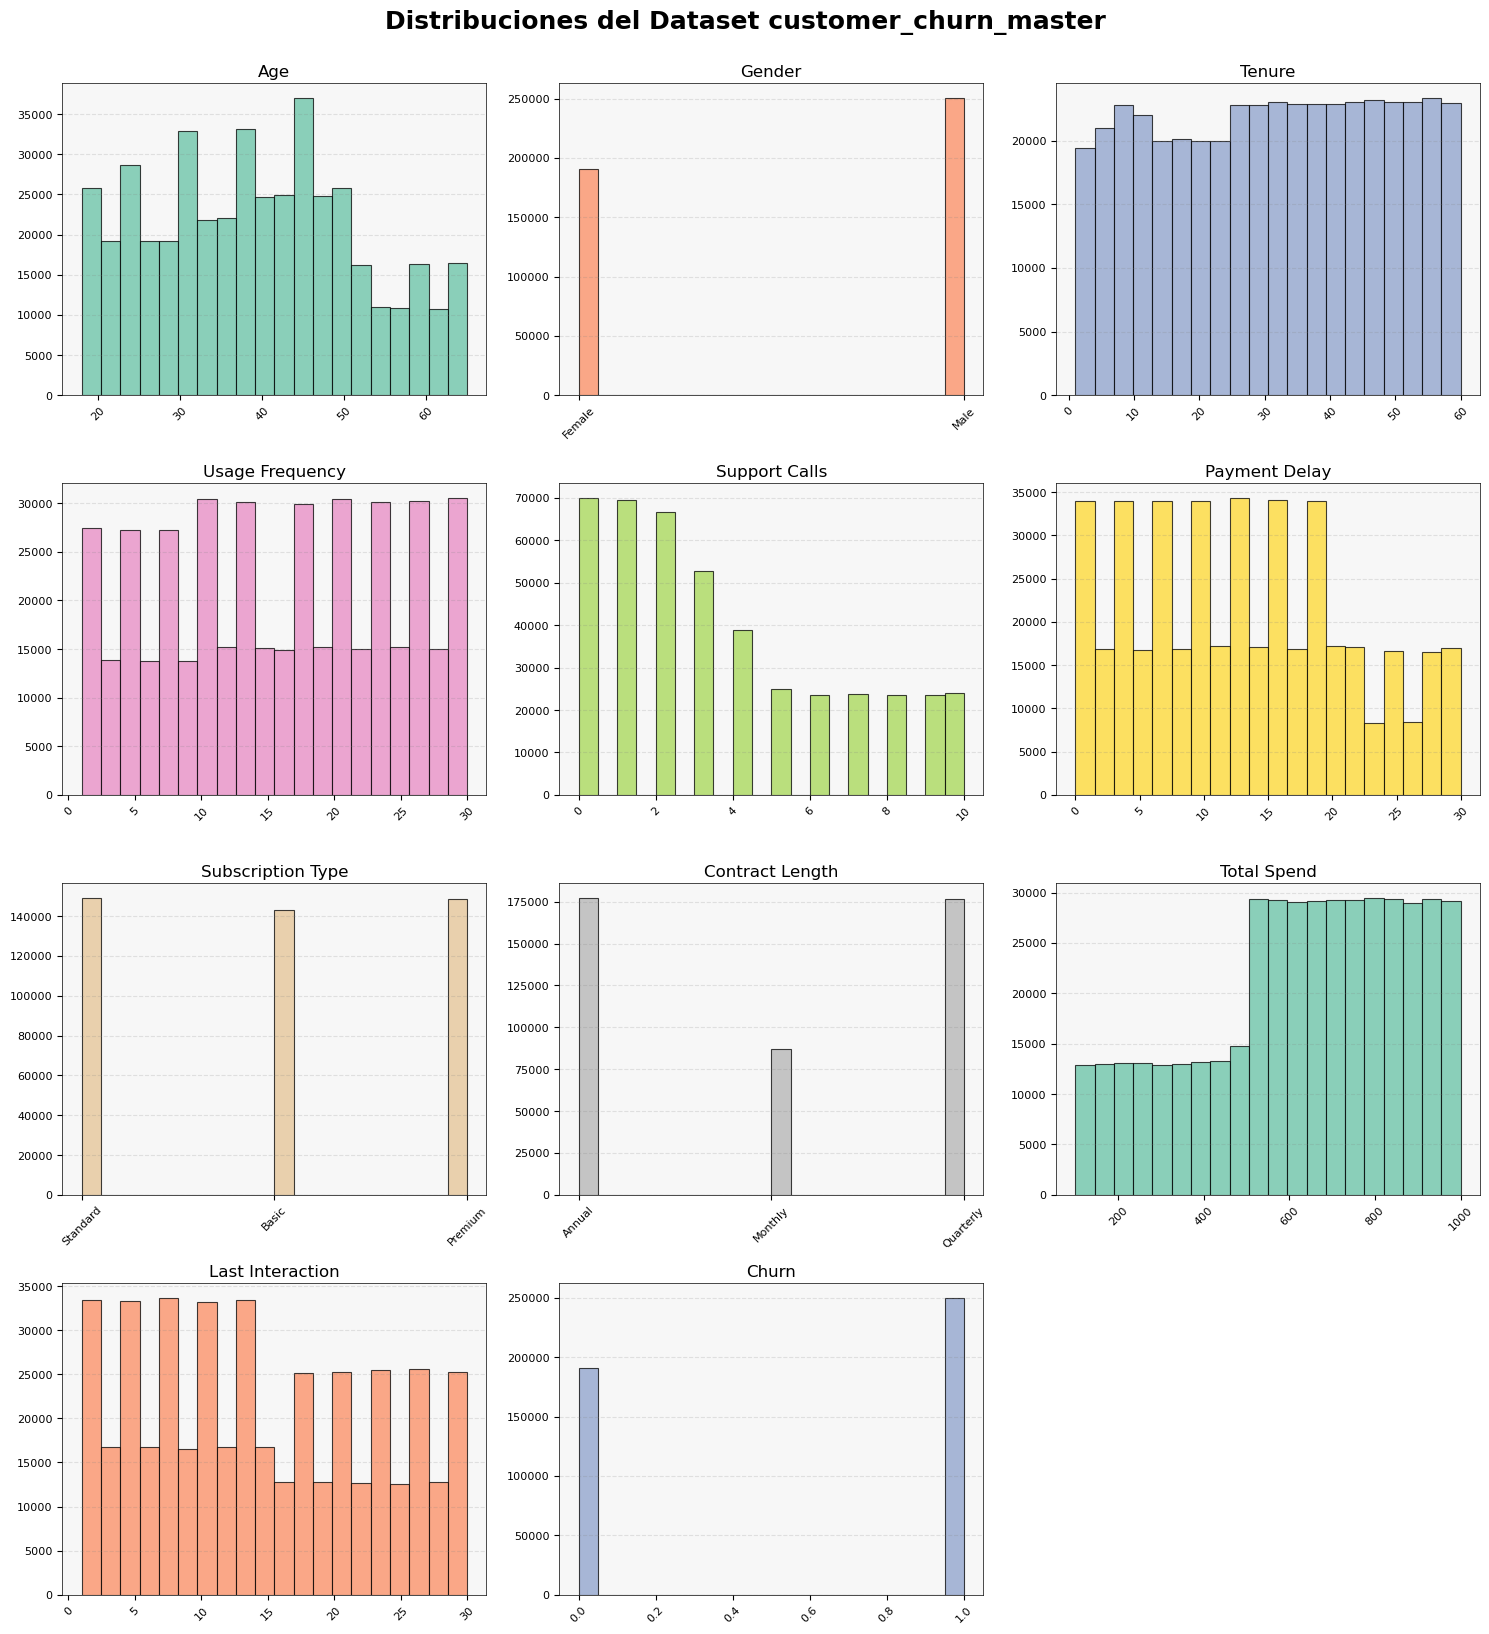

In [10]:
fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(15, 20)) 
axes = axes.flatten()

colors = sns.color_palette("Set2", len(df.columns))
for i, col in enumerate(df.columns):
    if i < len(axes):  
         # Cambiar a ax.hist()
        axes[i].hist(df[col].dropna(), bins='sturges', color=colors[i], alpha=0.75, edgecolor='black', linewidth=0.8)
        
        # Estética
        axes[i].set_title(col, fontsize=12, pad=5)
        axes[i].grid(axis='y', linestyle='--', color='gray', alpha=0.2)
        axes[i].set_facecolor('#f7f7f7')
        axes[i].spines['top'].set_color('black')
        axes[i].spines['top'].set_linewidth(0.5)
        axes[i].spines['right'].set_color('black')
        axes[i].spines['right'].set_linewidth(0.5)
        axes[i].spines['left'].set_color('black')
        axes[i].spines['left'].set_linewidth(0.5)
        axes[i].spines['bottom'].set_color('black')
        axes[i].spines['bottom'].set_linewidth(0.5)
        axes[i].tick_params(axis='x', rotation=45, labelsize=8, colors='black')
        axes[i].tick_params(axis='y', labelsize=8, colors='black')

# Eliminar ejes sobrantes
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Título general y espaciado
fig.suptitle('Distribuciones del Dataset customer_churn_master', fontsize=18, fontweight='bold', y= 1)
plt.tight_layout()
plt.show()

- **Age:** Tiene una distribución aproximadamente uniforme entre 20 y 60 años, con un ligero descenso en la frecuencia en los extremos (menores de 25 y mayores de 55 años).

- **Gender:** La cantidad de clientes está dividida casi equitativamente entre hombres y mujeres.

- **Tenure:** Distribución uniforme, lo que indica que los clientes tienen diferentes niveles de antigüedad con la empresa.

- **Usage Frequency:** Presenta una distribución uniforme en todas las categorías, lo que sugiere que el uso del servicio no tiene un sesgo fuerte hacia un nivel en particular.

- **Support Calls:** Se observa que la mayoría de los clientes realizan de 0 a 2 llamadas de soporte, con una caída significativa en frecuencias mayores a 3 llamadas.

- **Payment Delay:** La cantidad de clientes se distribuye de manera uniforme a través de las categorías de días de retraso, excepto por un leve descenso en los días más altos.

- **Subscription Type:** Distribución balanceada entre los tipos de suscripción estándar, básico y premium, lo que indica una oferta bien diversificada entre los usuarios.

- **Contract Length:** La mayoría de los clientes tienen contratos anuales, seguidos por los mensuales, con menor representación de los contratos trimestrales.

- **Total Spend:** La mayoría de los clientes tienen gastos acumulados entre 400 y 800, con un incremento en el número de clientes conforme el gasto aumenta hasta cerca de 800. Posteriormente, hay un ligero descenso.

- **Last Interaction:** Tiene una distribución uniforme, lo que sugiere que la última interacción de los clientes está bien distribuida a lo largo del tiempo.

- **Churn:** Variable binaria, con mayor número de clientes que no abandonaron (0) frente a los que abandonaron (1), indicando que el churn es relativamente bajo en este dataset.

#### **Consistencia en valores**

In [11]:
# Seleccionar las columnas categoricas
categorical_colums = df.select_dtypes(include=['object', 'category', 'bool'])
# Seleccionar las columnas numéricas
numerical_colums = df.select_dtypes(include=[np.number])

##### **Valores categoricos**

In [12]:
#Convierte las columnas objetc a category
categorical_colums = categorical_colums.apply(lambda col: pd.Categorical(col))

In [13]:
# Valores unicos mediante for
for col in categorical_colums.columns:
    print(f"Columna: {col}")
    print(f"Valores unicos: {df[col].unique()}")
    print()

Columna: Gender
Valores unicos: ['Female' 'Male']

Columna: Subscription Type
Valores unicos: ['Standard' 'Basic' 'Premium']

Columna: Contract Length
Valores unicos: ['Annual' 'Monthly' 'Quarterly']



**Analisis de variables categoricas por ***Subscription Type*****

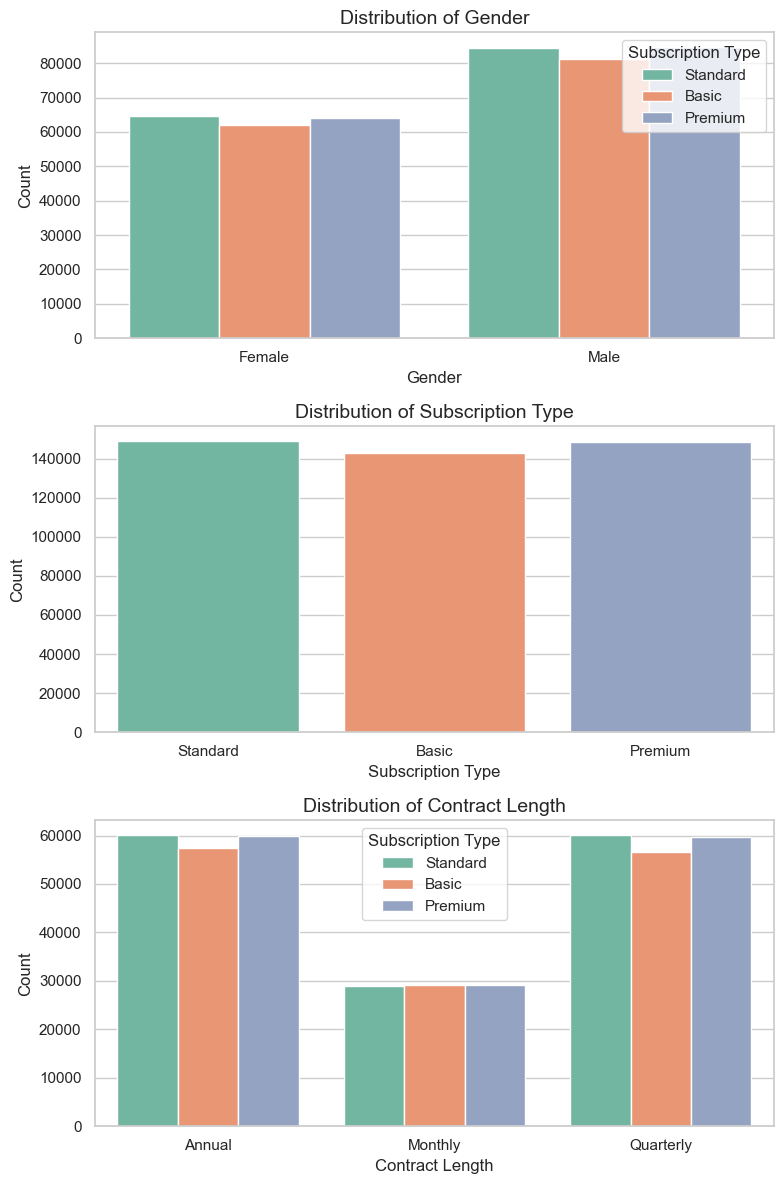

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_theme(style="whitegrid", palette="Set2")

# Identificar las columnas categóricas
categorical_columns = df.select_dtypes(include=['object']).columns

# Crear subplots
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(8, len(categorical_columns) * 4))

# Crear un gráfico por columna categórica
for ax, col in zip(axes, categorical_columns):
    sns.countplot(data=df, x=col, ax=ax, hue='Subscription Type')
    ax.set_title(f'Distribution of {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

**Analisis de variables categoricas por ***Gender*****

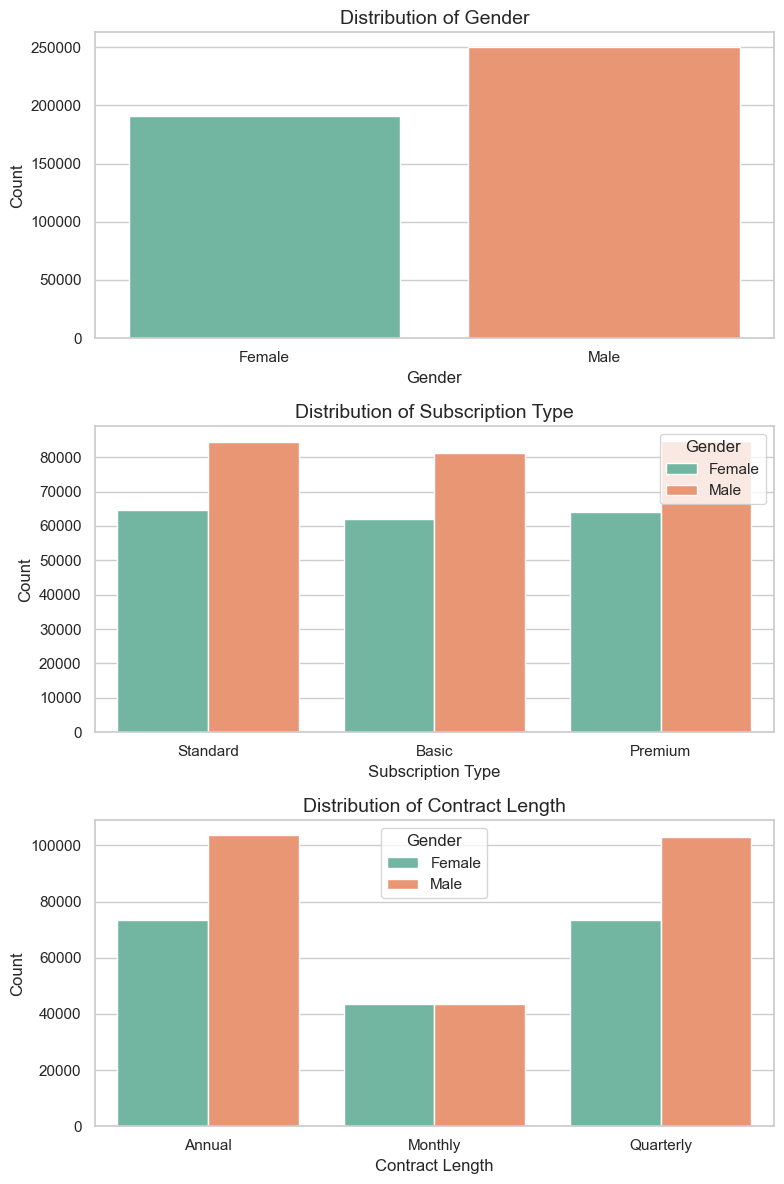

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_theme(style="whitegrid", palette="Set2")

# Identificar las columnas categóricas
categorical_columns = df.select_dtypes(include=['object']).columns

# Crear subplots
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(8, len(categorical_columns) * 4))

# Crear un gráfico por columna categórica
for ax, col in zip(axes, categorical_columns):
    sns.countplot(data=df, x=col, ax=ax, hue='Gender')
    ax.set_title(f'Distribution of {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()


**Analisis de variables categoricas por ***Contract Length*****

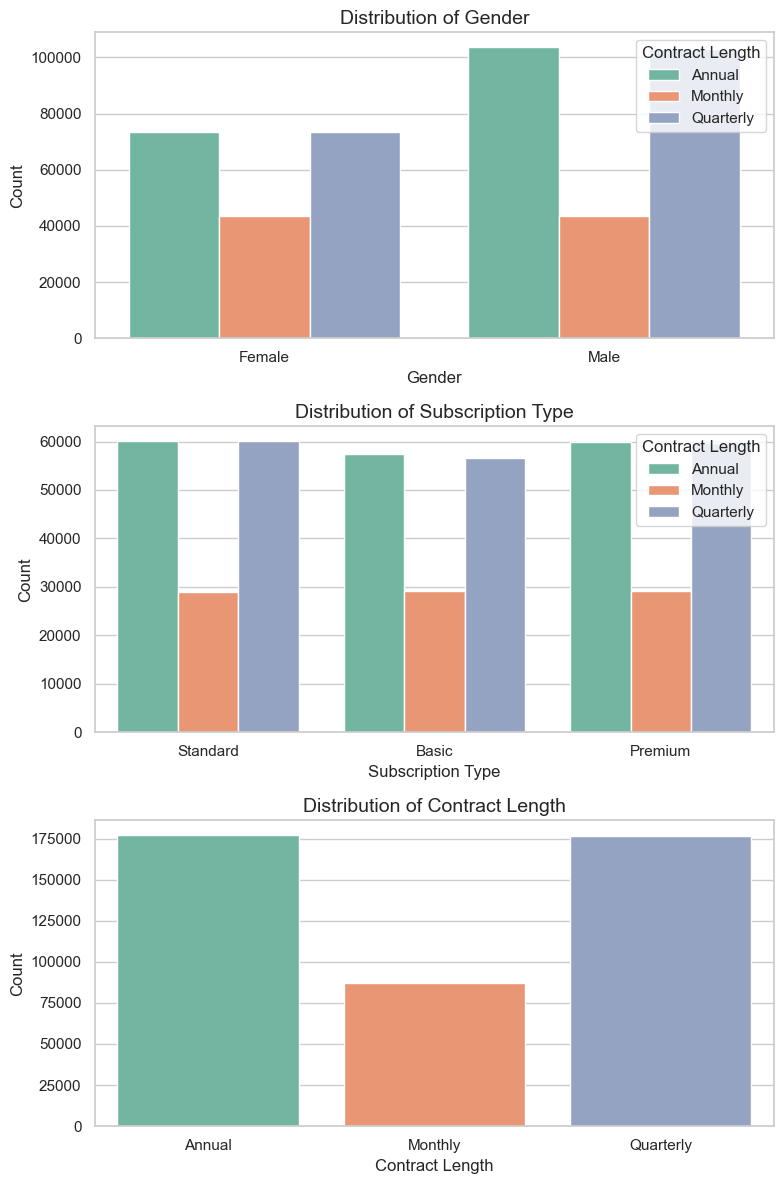

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurar estilo
sns.set_theme(style="whitegrid", palette="Set2")

# Identificar las columnas categóricas
categorical_columns = df.select_dtypes(include=['object']).columns

# Crear subplots
fig, axes = plt.subplots(nrows=len(categorical_columns), ncols=1, figsize=(8, len(categorical_columns) * 4))

# Crear un gráfico por columna categórica
for ax, col in zip(axes, categorical_columns):
    sns.countplot(data=df, x=col, ax=ax, hue='Contract Length')
    ax.set_title(f'Distribution of {col}', fontsize=14)
    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Count', fontsize=12)

# Ajustar diseño
plt.tight_layout()
plt.show()

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Age                440832 non-null  float64
 1   Gender             440832 non-null  object 
 2   Tenure             440832 non-null  float64
 3   Usage Frequency    440832 non-null  float64
 4   Support Calls      440832 non-null  float64
 5   Payment Delay      440832 non-null  float64
 6   Subscription Type  440832 non-null  object 
 7   Contract Length    440832 non-null  object 
 8   Total Spend        440832 non-null  float64
 9   Last Interaction   440832 non-null  float64
 10  Churn              440832 non-null  float64
dtypes: float64(8), object(3)
memory usage: 40.4+ MB


##### **Valores numericos**

In [18]:
data_dict = {
    'Age': 'int',
    'Tenure': 'int',
    'Usage Frequency': 'int',
    'Support Calls': 'int',	
    'Payment Delay': 'int',
    'Total Spend': 'float',
    'Last Interaction': 'int',
    'Churn': 'bool'
}

numerical_colums = numerical_colums.astype(data_dict)
numerical_colums.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 8 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Age               440832 non-null  int32  
 1   Tenure            440832 non-null  int32  
 2   Usage Frequency   440832 non-null  int32  
 3   Support Calls     440832 non-null  int32  
 4   Payment Delay     440832 non-null  int32  
 5   Total Spend       440832 non-null  float64
 6   Last Interaction  440832 non-null  int32  
 7   Churn             440832 non-null  bool   
dtypes: bool(1), float64(1), int32(6)
memory usage: 17.2 MB


In [19]:
# Valores unicos mediante for
for col in numerical_colums.columns:
    print(f"Columna: {col}")
    print(f"Valores unicos: {df[col].unique()}")
    print()

Columna: Age
Valores unicos: [30. 65. 55. 58. 23. 51. 39. 64. 29. 52. 22. 48. 24. 49. 19. 47. 42. 57.
 27. 59. 21. 60. 35. 18. 56. 20. 63. 25. 28. 32. 38. 37. 31. 53. 41. 33.
 26. 36. 44. 34. 61. 40. 45. 46. 54. 43. 50. 62.]

Columna: Tenure
Valores unicos: [39. 49. 14. 38. 32. 33. 37. 12.  3. 18. 21. 41. 35.  4. 56. 44. 15. 55.
 43. 52. 26.  2. 29. 59. 40. 51. 53. 24. 30.  6. 28. 17. 60.  7. 34. 10.
  5. 45. 54. 58. 25. 13. 47. 31. 22. 19. 23.  1.  8. 46. 16. 50. 48. 11.
 42. 27.  9. 20. 57. 36.]

Columna: Usage Frequency
Valores unicos: [14.  1.  4. 21. 20. 25. 12.  8.  5.  9.  6. 17. 23. 13. 16. 27.  2. 28.
 29. 15. 24.  3. 22. 26. 30.  7. 11. 18. 19. 10.]

Columna: Support Calls
Valores unicos: [ 5. 10.  6.  7.  9.  3.  4.  2.  0.  1.  8.]

Columna: Payment Delay
Valores unicos: [18.  8.  7. 26. 16. 15.  4. 11. 30. 25. 13. 22.  5. 14.  3. 10. 28.  2.
  6. 27. 12. 29. 17. 24.  9. 23. 21.  1.  0. 20. 19.]

Columna: Total Spend
Valores unicos: [932.   557.   185.   ... 829.59 804.3  9

#### **Analisis de Outliers**

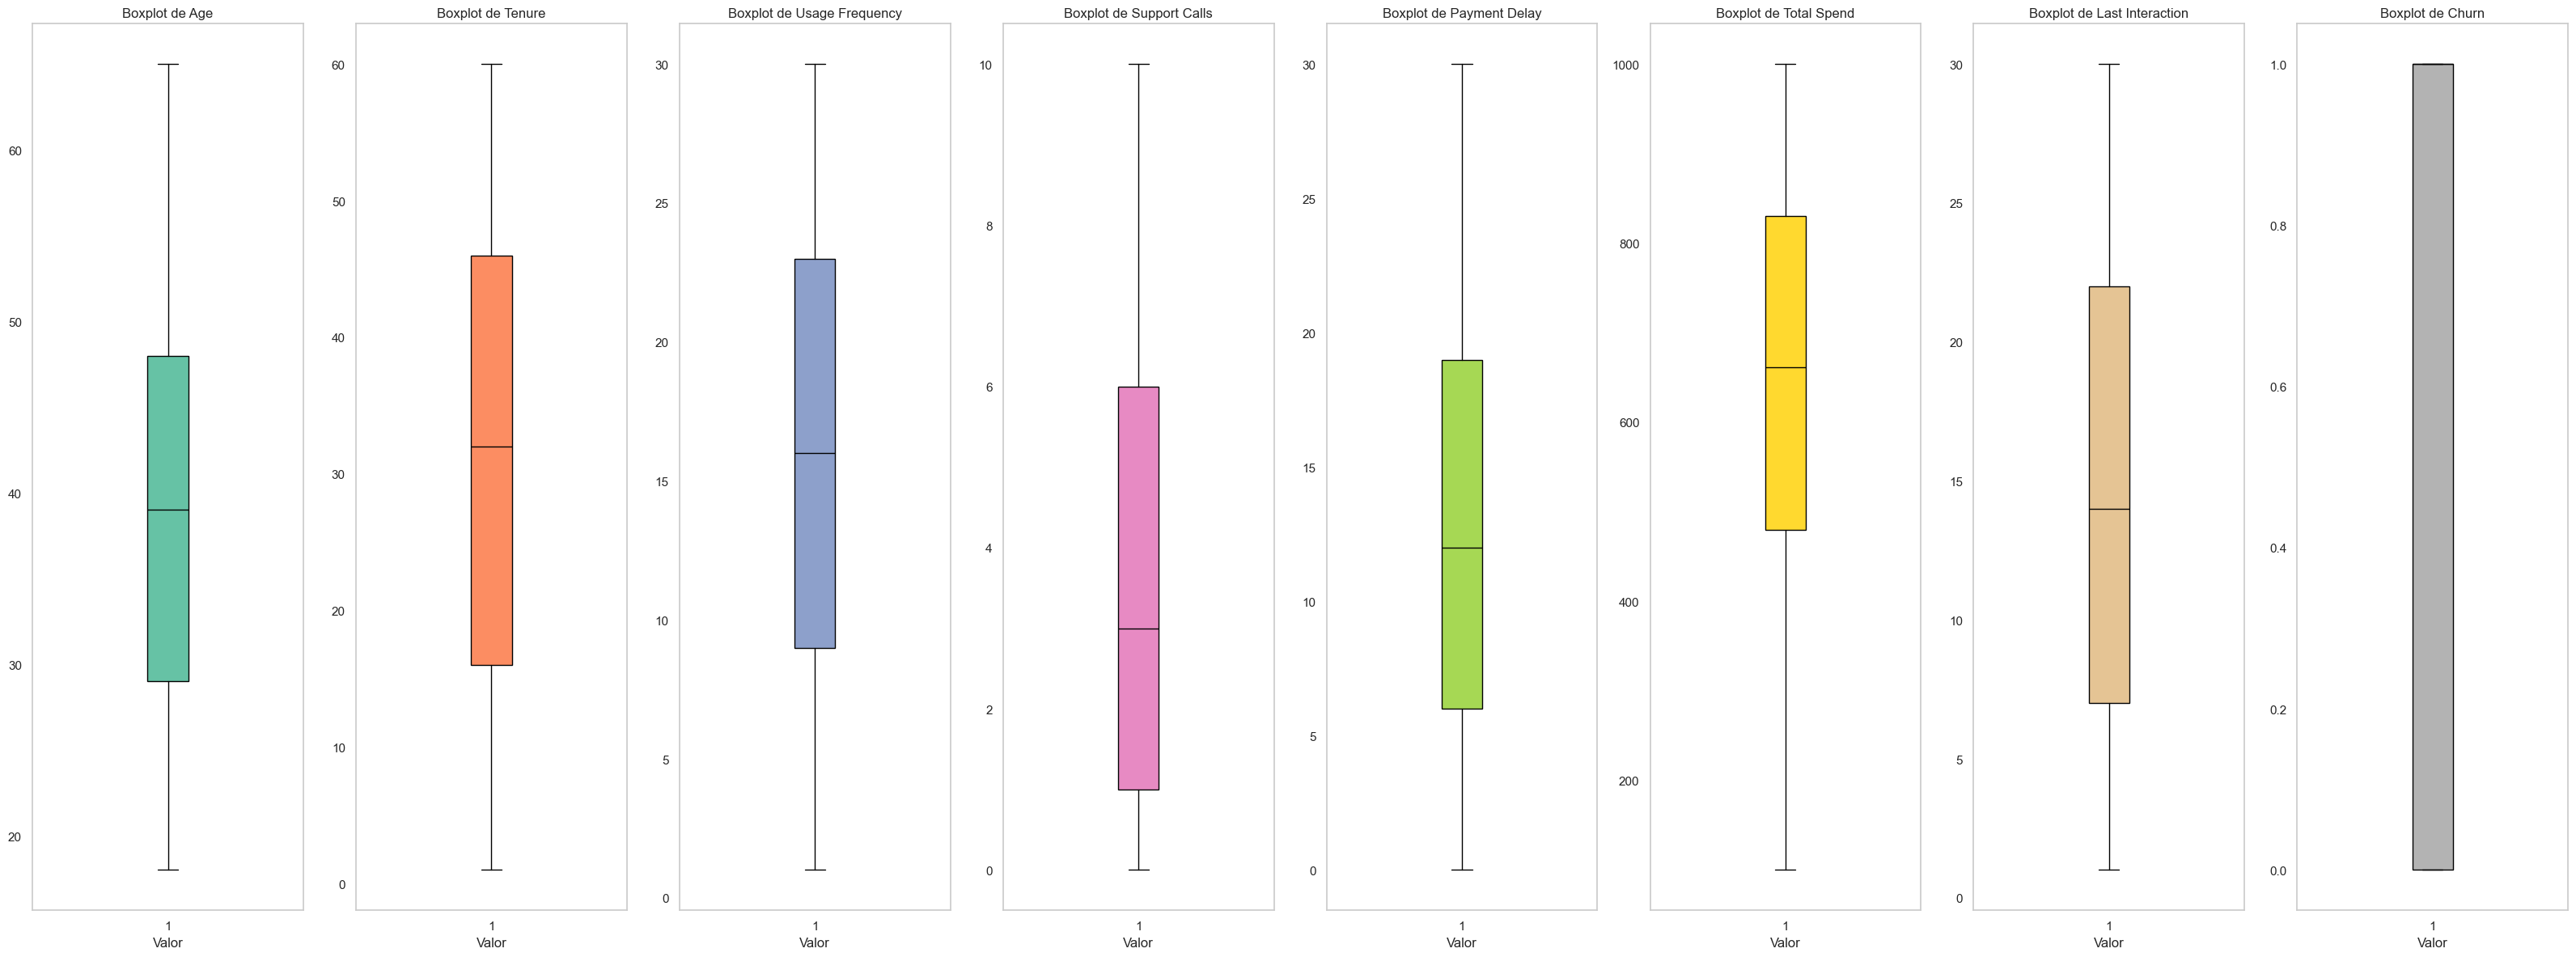

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Obtener el número de columnas que se desean graficar
num_cols = df.select_dtypes(include=[np.number]).shape[1]  # Solo columnas numéricas

# Crear un número adecuado de subgráficos con un máximo de 6 columnas por fila
ncols = 8  # Máximo 6 columnas por fila
nrows = -(-num_cols // ncols)  # Calcular filas necesarias, redondeando hacia arriba
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(4 * ncols, 12 * nrows))
axes = axes.flatten()  # Asegurarse de que 'axes' sea un arreglo plano


# Obtener una paleta de colores de seaborn
colors = sns.color_palette("Set2", num_cols)

# Graficar cada variable en un boxplot separado
for i, col in enumerate(df.select_dtypes(include=[np.number]).columns):
    # Convertir la columna a numérica, forzando valores no numéricos a NaN
    datos_columna = pd.to_numeric(df[col], errors='coerce')
    
    # Graficar solo si la columna contiene datos numéricos
    if datos_columna.dropna().shape[0] > 0:  # Verificar que haya valores válidos
        # Asignar color y modificar la línea de la mediana
        axes[i].boxplot(datos_columna, vert=True, patch_artist=True, 
                        boxprops=dict(facecolor=colors[i]),
                        medianprops=dict(color='black'))  # Línea de la mediana en negro
        axes[i].set_title(f'Boxplot de {col}')
        axes[i].set_xlabel('Valor')
        axes[i].grid()

# Ajustar el diseño
plt.tight_layout()
plt.show()


Para la variable ***Age (Edad)***, el rango intercuartil (IQR) se sitúa entre aproximadamente 30 y 50 años, con una mediana cercana a los 40 años. Esto indica que la mayoría de los clientes se encuentra dentro de este rango de edad y no hay valores atípicos destacados.

La variable ***Tenure (Antigüedad)*** refleja que los clientes suelen tener una antigüedad entre 15 y 45 meses, con una mediana alrededor de los 30 meses. Esto sugiere una distribución estable sin valores fuera de lo esperado.

En cuanto a ***Usage Frequency (Frecuencia de uso)***, los valores más comunes están entre 10 y 20 interacciones, con una mediana de aproximadamente 15. Esto sugiere un uso moderado de los servicios y, nuevamente, no se observan valores atípicos significativos.

La variable ***Support Calls (Llamadas de soporte)*** muestra que la mayoría de los clientes realizan entre 0 y 4 llamadas al servicio de soporte, con una mediana cercana a 2 llamadas. Esto indica que la mayoría de los usuarios tienen una interacción limitada con el soporte técnico.

Para ***Payment Delay (Retrasos en el pago)***, el IQR abarca retrasos entre 10 y 20 días, con una mediana en torno a los 15 días. La distribución parece ser uniforme y no presenta valores extremos, lo que sugiere un comportamiento de pagos relativamente consistente.

El gasto de los clientes, representado en ***Total Spend (Gasto total)***, se encuentra mayoritariamente entre 400 y 800 unidades, con una mediana alrededor de 600. Esto sugiere que los clientes tienen un gasto promedio consistente y no se observan anomalías en los datos.

***Last Interaction (Última interacción)*** indica que el tiempo desde la última interacción con el cliente varía entre 10 y 20 días, con una mediana en torno a los 15 días. La distribución es uniforme, sin valores atípicos que indiquen problemas en la periodicidad de las interacciones.

Por último, la variable ***Churn (Abandono)*** es binaria y muestra una separación clara entre los valores 0 y 1. La mediana se distribuye uniformemente, lo que indica que el dataset está balanceado entre clientes que abandonaron el servicio y los que no lo hicieron.

In [21]:
# Create a summary DataFrame for outliers
outliers_summary = pd.DataFrame()
for column in df.select_dtypes(include=[np.number]):
    outliers = utils.detect_outliers_iqr(df[column])
    outliers_summary[column] = {
        'Number of Outliers': outliers.sum(),
        'Percentage of Outliers': 100 * outliers.mean(),
        'Lower Bound': df[column][~outliers].min(),
        'Upper Bound': df[column][~outliers].max()
    }

outliers_summary.T

,Number of Outliers,Percentage of Outliers,Lower Bound,Upper Bound
Age,0.0,0.0,18.0,65.0
Tenure,0.0,0.0,1.0,60.0
Usage Frequency,0.0,0.0,1.0,30.0
Support Calls,0.0,0.0,0.0,10.0
Payment Delay,0.0,0.0,0.0,30.0
Total Spend,0.0,0.0,100.0,1000.0
Last Interaction,0.0,0.0,1.0,30.0
Churn,0.0,0.0,0.0,1.0


#### **Estadisticas descriptivas**

In [22]:
# Crear un diccionario para almacenar las estadísticas
estadisticas_dict = {}
# Iterar sobre cada columna numérica y calcular las estadísticas
for columna in numerical_colums:
    datos_columna = df[columna].values
    estadisticas = utils.calcular_estadisticas(columna, datos_columna)
    estadisticas_dict[columna] = estadisticas
# Convertir el diccionario a un DataFrame para una mejor visualización
estadisticas_df = pd.DataFrame(estadisticas_dict).T  # Transponer para que las columnas sean las filas
estadisticas_df = estadisticas_df[['Cuenta', 'Media', 'Mediana', 'Desviación Estándar', 
                                   'Mínimo', 'Máximo', '25% Percentil', '75% Percentil']]
# Redondear las estadísticas a 2 decimales
estadisticas_df = estadisticas_df.round(2)
# Mostrar el DataFrame formateado
print("\nEstadísticas Descriptivas (Redondeadas a 2 decimales):")
estadisticas_df


Estadísticas Descriptivas (Redondeadas a 2 decimales):


,Cuenta,Media,Mediana,Desviación Estándar,Mínimo,Máximo,25% Percentil,75% Percentil
Age,440832.0,39.37,39.0,12.44,18.0,65.0,29.0,48.0
Tenure,440832.0,31.26,32.0,17.26,1.0,60.0,16.0,46.0
Usage Frequency,440832.0,15.81,16.0,8.59,1.0,30.0,9.0,23.0
Support Calls,440832.0,3.60,3.0,3.07,0.0,10.0,1.0,6.0
Payment Delay,440832.0,12.97,12.0,8.26,0.0,30.0,6.0,19.0
Total Spend,440832.0,631.62,661.0,240.80,100.0,1000.0,480.0,830.0
Last Interaction,440832.0,14.48,14.0,8.60,1.0,30.0,7.0,22.0
Churn,440832.0,0.57,1.0,0.50,0.0,1.0,0.0,1.0


#### **Correlaciones**

In [23]:
# Concatenar las columnas estandarizadas
data_clean = pd.concat([categorical_colums, numerical_colums], axis=1)

# Verificar el resultado
data_clean.head().info()


<class 'pandas.core.frame.DataFrame'>
Index: 5 entries, 0 to 4
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Gender             5 non-null      category
 1   Subscription Type  5 non-null      category
 2   Contract Length    5 non-null      category
 3   Age                5 non-null      int32   
 4   Tenure             5 non-null      int32   
 5   Usage Frequency    5 non-null      int32   
 6   Support Calls      5 non-null      int32   
 7   Payment Delay      5 non-null      int32   
 8   Total Spend        5 non-null      float64 
 9   Last Interaction   5 non-null      int32   
 10  Churn              5 non-null      bool    
dtypes: bool(1), category(3), float64(1), int32(6)
memory usage: 608.0 bytes


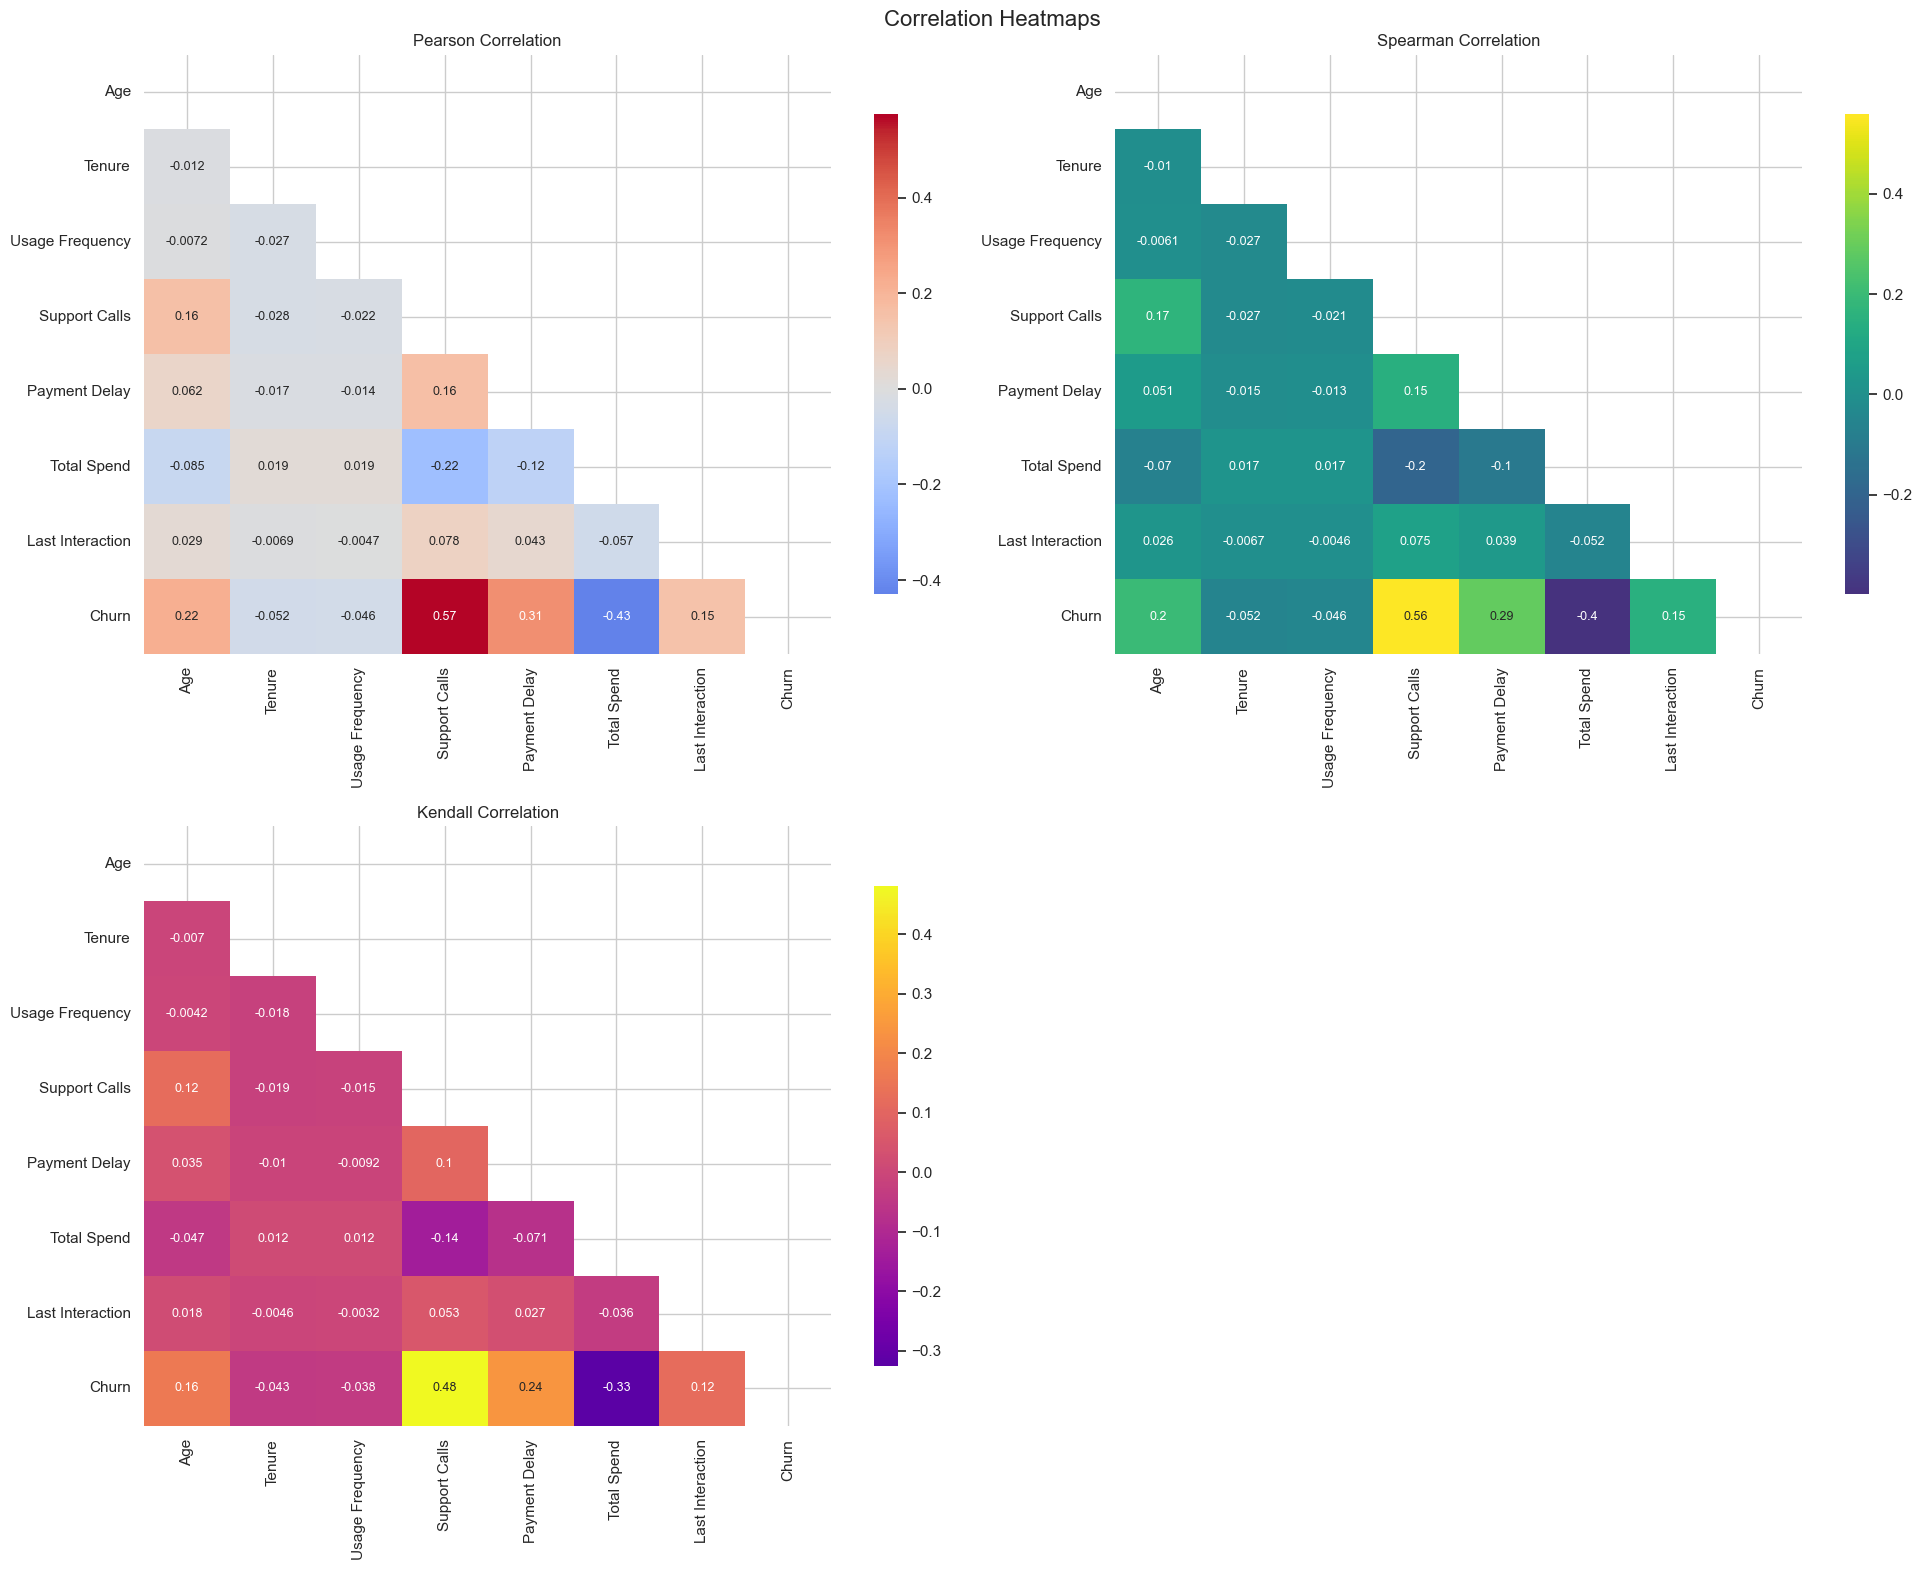

In [24]:
pearson_corr = numerical_colums.corr(method='pearson')
spearman_corr = numerical_colums.corr(method='spearman')
kendall_corr = numerical_colums.corr(method='kendall')

utils.graph_correlations(
    pearson_corr, 
    spearman_corr, 
    kendall_corr, 
    title="Correlation Heatmaps", 
    figsize=(20, 16),
    annot_size=9
)

Text(0, 0.5, 'Features')

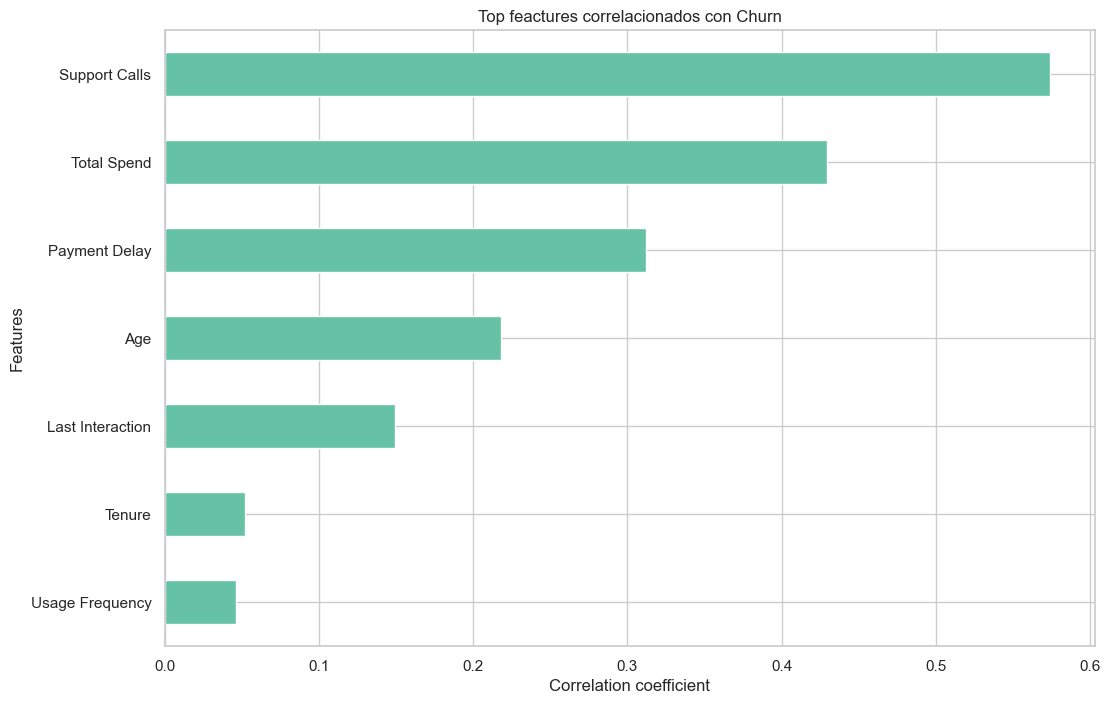

In [25]:
# Crear un top 5 de las correlaciones mas altas en base a nuestra variable objetivo y las graficamos
plt.figure(figsize=(12, 8))
numerical_colums.corr().Churn.apply(lambda x: abs(x)).sort_values(ascending=False).iloc[1:11][::-1].plot(kind='barh') 
plt.title("Top feactures correlacionados con Churn")
plt.xlabel("Correlation coefficient")
plt.ylabel("Features")

### **Modeling**

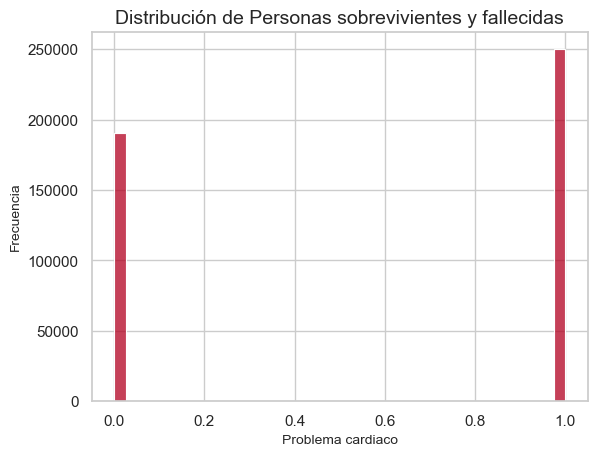

In [26]:
sns.histplot((data_clean['Churn']),color = '#B20020')
plt.title("Distribución de Personas sobrevivientes y fallecidas", fontsize=14)
plt.xlabel("Problema cardiaco", fontsize=10)  
plt.ylabel("Frecuencia", fontsize=10) 
plt.show()

In [27]:
data_clean.head(10)

,Gender,Subscription Type,Contract Length,Age,Tenure,Usage Frequency,Support Calls,Payment Delay,Total Spend,Last Interaction,Churn
0,Female,Standard,Annual,30,39,14,5,18,932.0,17,True
1,Female,Basic,Monthly,65,49,1,10,8,557.0,6,True
2,Female,Basic,Quarterly,55,14,4,6,18,185.0,3,True
3,Male,Standard,Monthly,58,38,21,7,7,396.0,29,True
4,Male,Basic,Monthly,23,32,20,5,8,617.0,20,True
5,Male,Premium,Annual,51,33,25,9,26,129.0,8,True
6,Female,Standard,Quarterly,58,49,12,3,16,821.0,24,True
7,Female,Premium,Annual,55,37,8,4,15,445.0,30,True
8,Male,Standard,Quarterly,39,12,5,7,4,969.0,13,True
9,Female,Standard,Quarterly,64,3,25,2,11,415.0,29,True


In [28]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 440832 entries, 0 to 440832
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   Gender             440832 non-null  category
 1   Subscription Type  440832 non-null  category
 2   Contract Length    440832 non-null  category
 3   Age                440832 non-null  int32   
 4   Tenure             440832 non-null  int32   
 5   Usage Frequency    440832 non-null  int32   
 6   Support Calls      440832 non-null  int32   
 7   Payment Delay      440832 non-null  int32   
 8   Total Spend        440832 non-null  float64 
 9   Last Interaction   440832 non-null  int32   
 10  Churn              440832 non-null  bool    
dtypes: bool(1), category(3), float64(1), int32(6)
memory usage: 18.5 MB


Dado que el dataset es muy grande, decido tomar muestras del 20% del total

In [29]:
# Selecciona una muestra aleatoria del 20% de los datos
sample = data_clean.sample(frac=0.2, random_state=42)

# Imprime las primeras 5 filas de la muestra
sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 88166 entries, 159565 to 136393
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   Gender             88166 non-null  category
 1   Subscription Type  88166 non-null  category
 2   Contract Length    88166 non-null  category
 3   Age                88166 non-null  int32   
 4   Tenure             88166 non-null  int32   
 5   Usage Frequency    88166 non-null  int32   
 6   Support Calls      88166 non-null  int32   
 7   Payment Delay      88166 non-null  int32   
 8   Total Spend        88166 non-null  float64 
 9   Last Interaction   88166 non-null  int32   
 10  Churn              88166 non-null  bool    
dtypes: bool(1), category(3), float64(1), int32(6)
memory usage: 3.7 MB


In [30]:
# Dividir datos en características y variable objetivo
X = sample.drop("Churn", axis=1)
y = sample["Churn"]

# Dividir datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir las columnas categóricas y numéricas
categorical_features = X.select_dtypes(include=["category"]).columns.tolist()
numerical_features = X.select_dtypes(include=["float64", "int32"]).columns.tolist()

# Crear el preprocesador
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first"), categorical_features),
        ("num", StandardScaler(), numerical_features),
    ]
)

In [31]:
# Crear pipeline
pipeline_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(random_state=42, max_iter=1000))
])

# Entrenar y evaluar
pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)
cv_scores_lr = cross_val_score(pipeline_lr, X_train, y_train, cv=5)

print("Logistic Regression")
print(f"Mean Cross-Validation Accuracy: {cv_scores_lr.mean():.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression
Mean Cross-Validation Accuracy: 0.8960

Classification Report:
              precision    recall  f1-score   support

       False       0.87      0.91      0.89      7617
        True       0.93      0.89      0.91     10017

    accuracy                           0.90     17634
   macro avg       0.90      0.90      0.90     17634
weighted avg       0.90      0.90      0.90     17634



In [32]:
# Crear pipeline
pipeline_gb = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(random_state=42))
])

# Entrenar y evaluar
pipeline_gb.fit(X_train, y_train)
y_pred_gb = pipeline_gb.predict(X_test)
cv_scores_gb = cross_val_score(pipeline_gb, X_train, y_train, cv=5)

print("Gradient Boosting")
print(f"Mean Cross-Validation Accuracy: {cv_scores_gb.mean():.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_gb))

Gradient Boosting
Mean Cross-Validation Accuracy: 0.9971

Classification Report:
              precision    recall  f1-score   support

       False       0.99      1.00      1.00      7617
        True       1.00      0.99      1.00     10017

    accuracy                           1.00     17634
   macro avg       1.00      1.00      1.00     17634
weighted avg       1.00      1.00      1.00     17634



In [33]:
# Crear pipeline con SAMME
pipeline_ab = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", AdaBoostClassifier(algorithm='SAMME', random_state=42))
])

# Entrenar y evaluar
pipeline_ab.fit(X_train, y_train)
y_pred_ab = pipeline_ab.predict(X_test)
cv_scores_ab = cross_val_score(pipeline_ab, X_train, y_train, cv=5)

print("AdaBoost")
print(f"Mean Cross-Validation Accuracy: {cv_scores_ab.mean():.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_ab))


AdaBoost
Mean Cross-Validation Accuracy: 0.9737

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97      7617
        True       1.00      0.96      0.98     10017

    accuracy                           0.98     17634
   macro avg       0.97      0.98      0.98     17634
weighted avg       0.98      0.98      0.98     17634



In [34]:
# Crear pipeline
pipeline_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(random_state=42, eval_metric="logloss"))
])

# Entrenar y evaluar
pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)
cv_scores_xgb = cross_val_score(pipeline_xgb, X_train, y_train, cv=5)

print("XGBoost")
print(f"Mean Cross-Validation Accuracy: {cv_scores_xgb.mean():.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost
Mean Cross-Validation Accuracy: 0.9998

Classification Report:
              precision    recall  f1-score   support

       False       1.00      1.00      1.00      7617
        True       1.00      1.00      1.00     10017

    accuracy                           1.00     17634
   macro avg       1.00      1.00      1.00     17634
weighted avg       1.00      1.00      1.00     17634



#### **Optimización de Modelos**

In [35]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report

def optimize_and_evaluate(model, param_distributions, X_train, y_train, X_test, y_test):
    # Randomized Search CV
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions,
        n_iter=50,
        scoring="roc_auc",
        cv=5,
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train, y_train)
    
    # Best Model
    best_model = search.best_estimator_
    
    # Predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    
    # Evaluation Metrics
    metrics = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred),
        "roc_auc": roc_auc_score(y_test, y_pred_proba)
    }
    
    print("Best Parameters:", search.best_params_)
    print("Classification Report:\n", classification_report(y_test, y_pred))
    print("Evaluation Metrics:", metrics)
    return best_model, metrics


In [39]:
from xgboost import XGBClassifier

# XGBoost Parameter Grid
param_distributions_xgb = {
    "classifier__n_estimators": [50, 100, 200],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__max_depth": [3, 5, 7],
    "classifier__subsample": [0.6, 0.8, 1.0],
    "classifier__colsample_bytree": [0.6, 0.8, 1.0]
}

pipeline_xgb = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42))
])

print("XGBoost")
best_xgb, metrics_xgb = optimize_and_evaluate(pipeline_xgb, param_distributions_xgb, X_train, y_train, X_test, y_test)


XGBoost


c:\Users\guill\anaconda3\envs\mitic\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:03:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best Parameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 100, 'classifier__max_depth': 7, 'classifier__learning_rate': 0.2, 'classifier__colsample_bytree': 1.0}
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      7617
        True       1.00      1.00      1.00     10017

    accuracy                           1.00     17634
   macro avg       1.00      1.00      1.00     17634
weighted avg       1.00      1.00      1.00     17634

Evaluation Metrics: {'accuracy': 0.9997731654757854, 'precision': 0.999800339422981, 'recall': 0.999800339422981, 'f1_score': 0.999800339422981, 'roc_auc': 0.9999999213625139}


In [36]:
# Logistic Regression Parameter Grid
param_distributions_lr = {
    "classifier__C": [0.01, 0.1, 1, 10, 100],
    "classifier__solver": ["liblinear", "saga"],
    "classifier__penalty": ["l1", "l2"]
}

pipeline_lr = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000, random_state=42))
])

print("Logistic Regression")
best_lr, metrics_lr = optimize_and_evaluate(pipeline_lr, param_distributions_lr, X_train, y_train, X_test, y_test)


Logistic Regression


c:\Users\guill\anaconda3\envs\mitic\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'classifier__solver': 'saga', 'classifier__penalty': 'l2', 'classifier__C': 100}
Classification Report:
               precision    recall  f1-score   support

       False       0.87      0.91      0.89      7617
        True       0.93      0.89      0.91     10017

    accuracy                           0.90     17634
   macro avg       0.90      0.90      0.90     17634
weighted avg       0.90      0.90      0.90     17634

Evaluation Metrics: {'accuracy': 0.8989452194624021, 'precision': 0.9259335884969484, 'recall': 0.893580912448837, 'f1_score': 0.9094696199959358, 'roc_auc': 0.9609292665118636}


In [37]:
# Gradient Boosting Parameter Grid
param_distributions_gb = {
    "classifier__n_estimators": [20, 50, 80],
    "classifier__learning_rate": [0.01, 0.1, 0.2],
    "classifier__max_depth": [3, 5, 7],
    "classifier__subsample": [0.6, 0.8, 1.0]
}

pipeline_gb = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", GradientBoostingClassifier(random_state=42))
])

print("Gradient Boosting")
best_gb, metrics_gb = optimize_and_evaluate(pipeline_gb, param_distributions_gb, X_train, y_train, X_test, y_test)


Gradient Boosting
Best Parameters: {'classifier__subsample': 0.8, 'classifier__n_estimators': 80, 'classifier__max_depth': 3, 'classifier__learning_rate': 0.2}
Classification Report:
               precision    recall  f1-score   support

       False       1.00      1.00      1.00      7617
        True       1.00      1.00      1.00     10017

    accuracy                           1.00     17634
   macro avg       1.00      1.00      1.00     17634
weighted avg       1.00      1.00      1.00     17634

Evaluation Metrics: {'accuracy': 0.9996597482136781, 'precision': 0.9999001298312195, 'recall': 0.9995008485574524, 'f1_score': 0.999700449326011, 'roc_auc': 0.9999976015566763}


In [38]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost Parameter Grid
param_distributions_ab = {
    "classifier__n_estimators": [20, 50, 100],
    "classifier__learning_rate": [0.01, 0.1, 0.5, 1]
}

pipeline_ab = Pipeline([
    ("preprocessor", preprocessor),
    ("classifier", AdaBoostClassifier(random_state=42))
])

print("AdaBoost")
best_ab, metrics_ab = optimize_and_evaluate(pipeline_ab, param_distributions_ab, X_train, y_train, X_test, y_test)


AdaBoost


c:\Users\guill\anaconda3\envs\mitic\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=50. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
c:\Users\guill\anaconda3\envs\mitic\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best Parameters: {'classifier__n_estimators': 100, 'classifier__learning_rate': 0.5}
Classification Report:
               precision    recall  f1-score   support

       False       0.96      1.00      0.98      7617
        True       1.00      0.97      0.98     10017

    accuracy                           0.98     17634
   macro avg       0.98      0.98      0.98     17634
weighted avg       0.98      0.98      0.98     17634

Evaluation Metrics: {'accuracy': 0.9829307020528525, 'precision': 0.9977459016393443, 'recall': 0.97214734950584, 'f1_score': 0.9847803003488901, 'roc_auc': 0.997051212230268}


Graficos de CM y ROC Curve

In [40]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

def plot_metrics(model, X_test, y_test):
    # Predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Confusion Matrix
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.show()

    # ROC Curve
    RocCurveDisplay.from_estimator(model, X_test, y_test)
    plt.title("ROC Curve")
    plt.show()


Logistic Regression Metrics


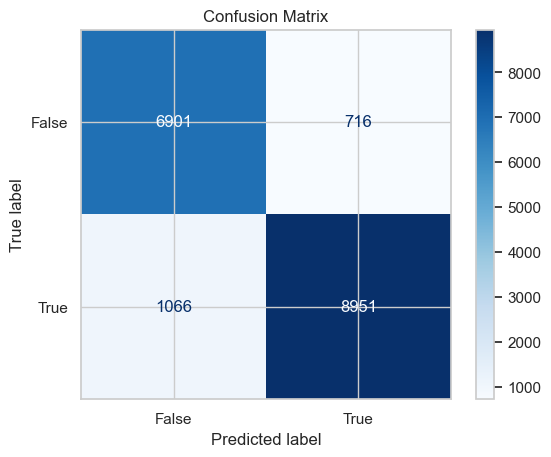

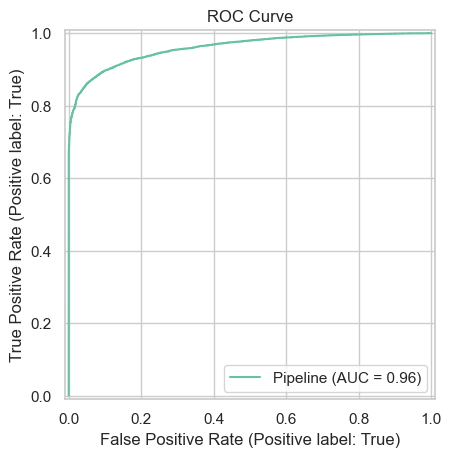

In [41]:
print("Logistic Regression Metrics")
plot_metrics(best_lr, X_test, y_test)


Gradient Boosting Metrics


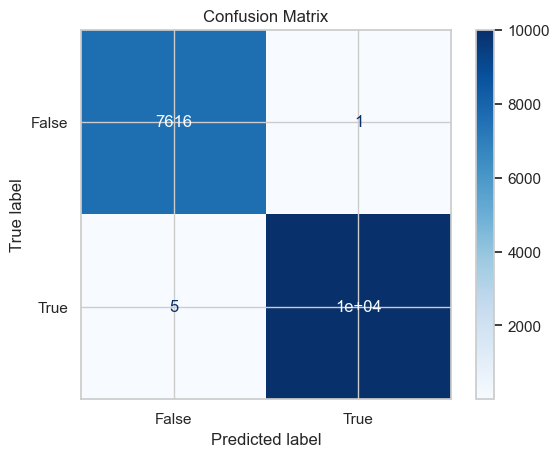

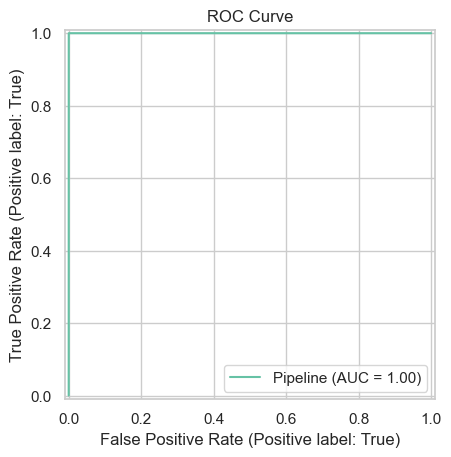

In [42]:
print("Gradient Boosting Metrics")
plot_metrics(best_gb, X_test, y_test)


AdaBoost Metrics


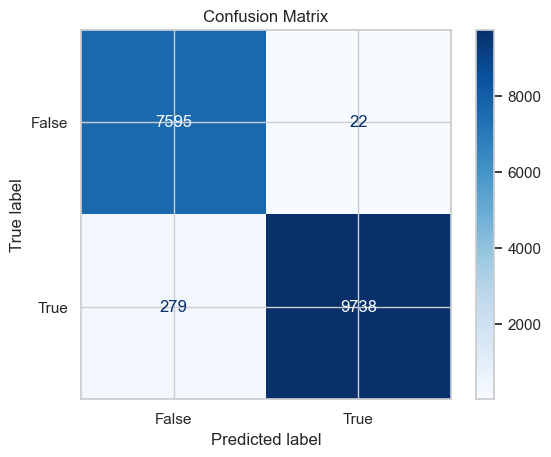

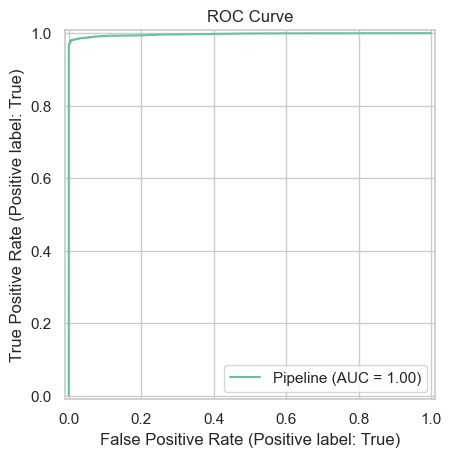

In [43]:
print("AdaBoost Metrics")
plot_metrics(best_ab, X_test, y_test)


XGBoost Metrics


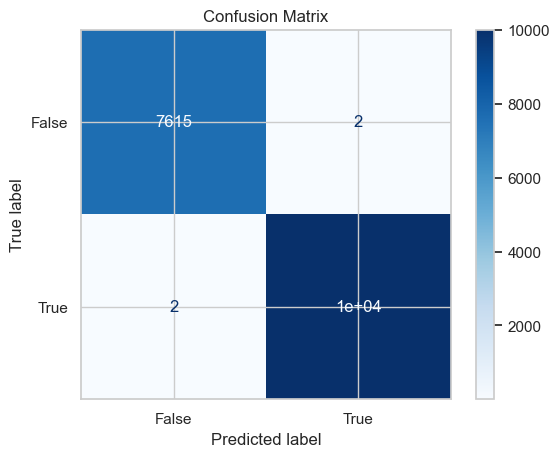

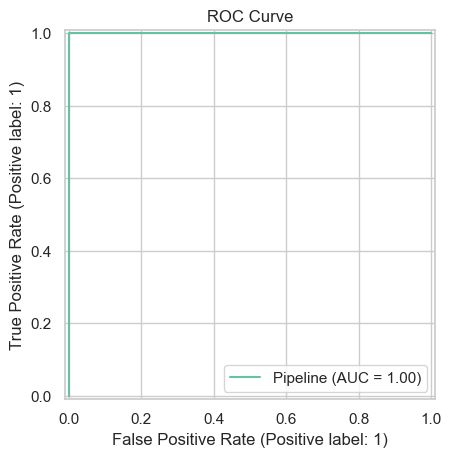

In [44]:
print("XGBoost Metrics")
plot_metrics(best_xgb, X_test, y_test)


In [47]:
# Asegúrate de que los modelos estén entrenados primero
pipeline_gb.fit(X_train, y_train)  # Entrenar el modelo GradientBoosting
pipeline_ab.fit(X_train, y_train)  # Entrenar el modelo AdaBoost
pipeline_xgb.fit(X_train, y_train)  # Entrenar el modelo XGBoost
pipeline_lr.fit(X_train, y_train)  # Entrenar el modelo LogisticRegression

# Evaluar métricas para cada modelo
y_pred_gb = pipeline_gb.predict(X_test)
y_pred_proba_gb = pipeline_gb.predict_proba(X_test)[:, 1]

y_pred_ab = pipeline_ab.predict(X_test)
y_pred_proba_ab = pipeline_ab.predict_proba(X_test)[:, 1]

y_pred_xb = pipeline_xgb.predict(X_test)
y_pred_proba_xb = pipeline_xgb.predict_proba(X_test)[:, 1]

y_pred_lr = pipeline_lr.predict(X_test)
y_pred_proba_lr = pipeline_lr.predict_proba(X_test)[:, 1]

# Evaluar cada modelo
gb_metrics = evaluate_model(y_test, y_pred_gb, y_pred_proba_gb)
ab_metrics = evaluate_model(y_test, y_pred_ab, y_pred_proba_ab)
xb_metrics = evaluate_model(y_test, y_pred_xb, y_pred_proba_xb)
lr_metrics = evaluate_model(y_test, y_pred_lr, y_pred_proba_lr)

# Comparar en un DataFrame
results = pd.DataFrame(
    [gb_metrics, ab_metrics, xb_metrics, lr_metrics],
    index=["GradientBoosting", "AdaBoost", "XGBoost", "LogisticRegression"],
)

print("Resultados comparativos:")
print(results)

# Identificar el modelo con mejor rendimiento en cada métrica
print("\nMejor modelo basado en las métricas:")
print(results.idxmax(axis=0))


c:\Users\guill\anaconda3\envs\mitic\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
c:\Users\guill\anaconda3\envs\mitic\Lib\site-packages\xgboost\core.py:158: UserWarning: [13:05:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Resultados comparativos:
                    Accuracy  Precision    Recall  F1-Score   ROC-AUC
GradientBoosting    0.996824   0.999900  0.994509  0.997197  0.999831
AdaBoost            0.984178   0.998056  0.974044  0.985904  0.997064
XGBoost             0.999887   0.999900  0.999900  0.999900  1.000000
LogisticRegression  0.899059   0.926037  0.893681  0.909571  0.960928

Mejor modelo basado en las métricas:
Accuracy     XGBoost
Precision    XGBoost
Recall       XGBoost
F1-Score     XGBoost
ROC-AUC      XGBoost
dtype: object


El modelo XGBOOST es bueno para predecir